# Introduction
In homework assignment 3, we will implement the deep deterministic policy gradient (DDPG) algorithm to solve a classic rocket trajectory optimization problem--Lunar Lander v2

# Enabling and testing the GPU

First, you may need to enable GPUs for this notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with pytorch:

In [1]:
import torch
import os
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Found device at: {}'.format(device))

Found device at: cuda:0


# Install gym environment

In [2]:
!pip install swig
!pip install gymnasium[box2d]

# Load tensorboard for visualizing

In [3]:
%load_ext tensorboard

# Import required package

In [4]:
import torch.nn as nn
from typing import Tuple
from collections import namedtuple
from collections import deque
import numpy.random as nr
import numpy as np
import torch.nn.functional as F

import gymnasium as gym
from torch.utils.tensorboard import SummaryWriter

import datetime
import copy

Tensor = torch.DoubleTensor
torch.set_default_tensor_type(Tensor)
Transitions = namedtuple('Transitions', ['obs', 'action', 'reward', 'next_obs', 'done'])

E:\UCR_Projects\RLProject\RLenv\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


# Replay buffer

In [5]:
class ReplayBuffer(nn.Module):
    def __init__(self, config):
        # super().__init__()
        replay_buffer_size = config['replay_buffer_size']
        seed = config['seed']
        self.device = config['device']
        nr.seed(seed)

        self.replay_buffer_size = replay_buffer_size
        self.obs = deque([], maxlen=self.replay_buffer_size)
        self.action = deque([], maxlen=self.replay_buffer_size)
        self.reward = deque([], maxlen=self.replay_buffer_size)
        self.next_obs = deque([], maxlen=self.replay_buffer_size)
        self.done = deque([], maxlen=self.replay_buffer_size)

    def append_memory(self,
                      obs,
                      action,
                      reward,
                      next_obs,
                      done: bool):
        self.obs.append(obs)
        self.action.append(action)
        self.reward.append(reward)
        self.next_obs.append(next_obs)
        self.done.append(done)

    def sample(self, batch_size):
        buffer_size = len(self.obs)

        idx = nr.choice(buffer_size,
                        size=min(buffer_size, batch_size),
                        replace=False)
        t = Transitions
        t.obs = torch.stack(list(map(self.obs.__getitem__, idx))).to(self.device)
        t.action = torch.stack(list(map(self.action.__getitem__, idx))).to(self.device)
        t.reward = torch.stack(list(map(self.reward.__getitem__, idx))).to(self.device)
        t.next_obs = torch.stack(list(map(self.next_obs.__getitem__, idx))).to(self.device)
        t.done = torch.tensor(list(map(self.done.__getitem__, idx)))[:, None].to(self.device)
        return t

    def clear(self):
        self.obs = deque([], maxlen=self.replay_buffer_size)
        self.action = deque([], maxlen=self.replay_buffer_size)
        self.reward = deque([], maxlen=self.replay_buffer_size)
        self.next_obs = deque([], maxlen=self.replay_buffer_size)
        self.done = deque([], maxlen=self.replay_buffer_size)

# Actor network

In [6]:
class ActorNet(nn.Module):
    def __init__(self,
                 dim_obs: int,
                 dim_action: int,
                 dims_hidden_neurons: Tuple[int] = (64, 64)):
        super(ActorNet, self).__init__()
        self.n_layers = len(dims_hidden_neurons)
        self.dim_action = dim_action

        n_neurons = (dim_obs,) + dims_hidden_neurons + (dim_action,)
        for i, (dim_in, dim_out) in enumerate(zip(n_neurons[:-2], n_neurons[1:-1])):
            layer = nn.Linear(dim_in, dim_out).double()
            # nn.Linear: input: (batch_size, n_feature)
            #            output: (batch_size, n_output)
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
            exec('self.layer{} = layer'.format(i + 1))  # exec(str): execute a short program written in the str

        self.output = nn.Linear(n_neurons[-2], n_neurons[-1]).double()
        torch.nn.init.xavier_uniform_(self.output.weight)
        torch.nn.init.zeros_(self.output.bias)

    def forward(self, obs: torch.Tensor):
        x = obs
        for i in range(self.n_layers):
            x = eval('torch.relu(self.layer{}(x))'.format(i + 1))
        a = torch.tanh(self.output(x))
        return a


# Critic network

In [7]:
class QCriticNet(nn.Module):
    def __init__(self,
                 dim_obs: int,
                 dim_action: int,
                 dims_hidden_neurons: Tuple[int] = (64, 64)):
        super(QCriticNet, self).__init__()
        self.n_layers = len(dims_hidden_neurons)
        self.dim_action = dim_action

        n_neurons = (dim_obs + dim_action,) + dims_hidden_neurons + (1,)
        for i, (dim_in, dim_out) in enumerate(zip(n_neurons[:-2], n_neurons[1:-1])):
            layer = nn.Linear(dim_in, dim_out).double()
            # nn.Linear: input: (batch_size, n_feature)
            #            output: (batch_size, n_output)
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
            exec('self.layer{} = layer'.format(i + 1))  # exec(str): execute a short program written in the str

        self.output = nn.Linear(n_neurons[-2], n_neurons[-1]).double()
        torch.nn.init.xavier_uniform_(self.output.weight)
        torch.nn.init.zeros_(self.output.bias)

    def forward(self, obs: torch.Tensor, action: torch.Tensor):
        x = torch.cat((obs, action), dim=1)
        for i in range(self.n_layers):
            x = eval('torch.relu(self.layer{}(x))'.format(i + 1))
        return self.output(x)


# DDPG agent
The base code are given in this section. The updates of the actor and critic networks are missing and are left out for you to fill. You may refer to the DDPG paper https://arxiv.org/pdf/1509.02971.pdf or Spinning up tutorial for DDPG https://spinningup.openai.com/en/latest/algorithms/ddpg.html

## Overview of DDPG Algorithm's Update Function

The update function of the Deep Deterministic Policy Gradient (DDPG) algorithm plays a crucial role in the learning process, enabling simultaneous updates of both actor and critic networks. The function starts by sampling a batch of experiences from the replay buffer. These experiences, consisting of states, actions, rewards, next states, and done flags, form the foundation for training the networks.

### Critic Network Training

For the critic network, the function calculates the current Q-values using the current states and actions. It then predicts the next actions using the target actor network and calculates the target Q-values from these next actions using the target critic network. The target Q-values are discounted and adjusted by the rewards and the termination flags to account for the end of episodes. The loss is computed as the mean squared error between the current Q-values and the target Q-values, driving the gradient descent step to minimize this loss. This step updates the critic network's weights, aiming to better approximate the expected returns.

### Actor Network Training and Target Networks Update

Parallel to the critic update, the actor network is trained to maximize the critic's estimated Q-values by generating actions that lead to higher returns. The loss for the actor is defined as the negative mean of these Q-values, which promotes actions leading to higher rewards. After computing the gradient of this loss, the actor's weights are adjusted to steer the policy towards optimal actions. Following the updates of the actor and critic networks, the target networks are softly updated. This involves slowly blending the trained networks' weights into the target networks using a defined smoothing factor, ensuring stability in the learning updates and reducing the risk of large deviations in policy performance.


In [13]:
class DDPG(nn.Module):
    def __init__(self, config):
        super(DDPG,self).__init__()
        torch.manual_seed(config['seed'])

        self.lr_actor = config['lr_actor']  # learning rate
        self.lr_critic = config['lr_critic']
        self.smooth = config['smooth']  # smoothing coefficient for target net
        self.discount = config['discount']  # discount factor
        self.batch_size = config['batch_size']  # mini batch size
        self.sig = config['sig']  # exploration noise

        self.dims_hidden_neurons = config['dims_hidden_neurons']
        self.dim_obs = config['dim_obs']
        self.dim_action = config['dim_action']

        self.device = config['device']

        self.actor = ActorNet(dim_obs=self.dim_obs,
                              dim_action=self.dim_action,
                              dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.Q = QCriticNet(dim_obs=self.dim_obs,
                            dim_action=self.dim_action,
                            dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.actor_tar = ActorNet(dim_obs=self.dim_obs,
                                  dim_action=self.dim_action,
                                  dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)
        self.Q_tar = QCriticNet(dim_obs=self.dim_obs,
                                dim_action=self.dim_action,
                                dims_hidden_neurons=self.dims_hidden_neurons).to(self.device)

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.optimizer_Q = torch.optim.Adam(self.Q.parameters(), lr=self.lr_critic)

    def update(self, buffer):
        # sample from replay memory
        t = buffer.sample(self.batch_size)

        # TO DO: Perform the updates for the actor and critic networks
        (states, actions, rewards, next_states, dones) = (t.obs, t.action, t.reward, t.next_obs, t.done)

        # train q-network
        Q_current_value = self.Q(states, actions)
        Q_target_value = rewards + self.discount * self.Q_tar(next_states, self.actor_tar(next_states)) * (1 - dones.float())
        loss = F.mse_loss(Q_current_value, Q_target_value)
        
        self.optimizer_Q.zero_grad()
        loss.backward()
        self.optimizer_Q.step()

        # train actor-network
        greedy_actions = self.actor(states)
        loss = -self.Q(states, greedy_actions).mean()
        
        self.optimizer_actor.zero_grad()
        loss.backward()
        self.optimizer_actor.step()

        # Update target networks
        for target_param, param in zip(self.Q_tar.parameters(), self.Q.parameters()):
                target_param.data.copy_(self.smooth * param.data + (1 - self.smooth) * target_param.data)
            
        for target_param, param in zip(self.actor_tar.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.smooth * param.data + (1 - self.smooth) * target_param.data)
        


    def act_probabilistic(self, obs: torch.Tensor):
        self.actor.eval()
        exploration_noise = torch.normal(torch.zeros(size=(self.dim_action,)), self.sig).to(self.device)
        a = self.actor(obs) + exploration_noise
        self.actor.train()
        return a

    def act_deterministic(self, obs: torch.Tensor):
        self.actor.eval()
        a = self.actor(obs)
        self.actor.train()
        return a


# Create environment

In [14]:
env = gym.make('LunarLanderContinuous-v2')

config = {
    'dim_obs': 8,
    'dim_action': 2,
    'dims_hidden_neurons': (400, 200),
    'lr_actor': 0.001,
    'lr_critic': 0.005,
    # 'smooth': 0.99,
    'smooth': 0.001,
    'discount': 0.99,
    'sig': 0.01,
    'batch_size': 32,
    'replay_buffer_size': 20000,
    'seed': 3,
    'max_episode': 700,
    'device':device
}


# Create agent

In [15]:
ddpg = DDPG(config).to(device)
buffer = ReplayBuffer(config)

from datetime import datetime
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = f'tensorboard/ddpg/data_{current_time}_lr-{config["lr_actor"]},{config["lr_critic"]}_batch_size-{config["batch_size"]}_seed-{config["seed"]}'
train_writer = SummaryWriter(log_dir=log_dir)

# Start training

In [16]:
steps = 0
for i_episode in range(config['max_episode']):
    obs = env.reset()[0]
    done = False
    truncated = False
    t = 0
    ret = 0.
    while done is False and truncated is False:
        # env.render() 

        obs_tensor = torch.tensor(obs).type(Tensor).to(device)

        action = ddpg.act_probabilistic(obs_tensor[None, :]).detach().cpu().numpy()[0, :]

        next_obs, reward, done, truncated,_ = env.step(action)

        buffer.append_memory(obs=obs_tensor,
                             action=torch.from_numpy(action),
                             reward=torch.from_numpy(np.array([reward/10.0])),
                             next_obs=torch.from_numpy(next_obs).type(Tensor),
                             done=done)

        ddpg.update(buffer)

        t += 1
        steps += 1
        ret += reward

        obs = copy.deepcopy(next_obs)

        if done or truncated:
            print("Episode {} return {}".format(i_episode, ret))
        train_writer.add_scalar('Performance/episodic_return', ret, i_episode)

env.close()
train_writer.close()


Episode 0 return -651.2217352550025
Episode 1 return -482.73840078152165
Episode 2 return -638.3219998757055
Episode 3 return -283.58202341169743
Episode 4 return -246.10575098915353
Episode 5 return -305.9526152189876
Episode 6 return -369.25687306288313
Episode 7 return -376.3688392354434
Episode 8 return -144.48748064545578
Episode 9 return -384.4155410468393
Episode 10 return -582.3668331723618
Episode 11 return -281.58676360794107
Episode 12 return -423.352529891739
Episode 13 return -638.6099746940635
Episode 14 return -293.7095941999332
Episode 15 return -611.2171766230995
Episode 16 return -355.0423125861673
Episode 17 return -431.5666465322918
Episode 18 return -593.888139899444
Episode 19 return -300.0694585886493
Episode 20 return -363.4938418073872
Episode 21 return -227.3896709981899
Episode 22 return -336.53290346995914
Episode 23 return -239.84982188306648
Episode 24 return -428.92357551708307
Episode 25 return -507.8884096922088
Episode 26 return -262.05739228647803
Epi

# Visualizing

## DDPG Algorithm Performance

The DDPG algorithm was run for 700 episodes with two different seeds. The highest reward achieved was approximately 200, with the smoothed value around 100. Below is a plot showing the smoothed version of returns per episode for the two runs. This visualization helps in understanding the consistency and variability of the performance across different initializations.


### Comparison of DDPG and SAC in Terms of Noise in Results

Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC) are both popular reinforcement learning algorithms designed for continuous action spaces. DDPG is known for being more sensitive to hyperparameter settings and experiencing significant variance in its learning curve. This noise primarily stems from DDPG's reliance on deterministic policy updates combined with off-policy learning, which can lead to issues of stability due to the compounding of approximation errors in both the policy and value networks. Furthermore, DDPG's exploration is solely based on adding noise to the action outputs (e.g., Ornstein-Uhlenbeck process), which might not always ensure adequate exploration of the state space.

On the other hand, SAC incorporates entropy regularization into its objective, encouraging the policy to explore more diverse actions. This entropy term not only aids in exploration but also stabilizes the learning process by smoothing over the policy updates. The stochastic nature of the policy in SAC helps in better exploration and mitigates the risk of premature convergence to suboptimal policies, a challenge often faced by DDPG. Given these advantages, SAC generally results in smoother learning curves and more robust policies compared to DDPG. Thus, while DDPG might be simpler to implement and computationally less intensive, SAC's ability to maintain a balance between exploration and exploitation through entropy regularization generally makes it a superior choice for tasks requiring reliable performance in complex environments.


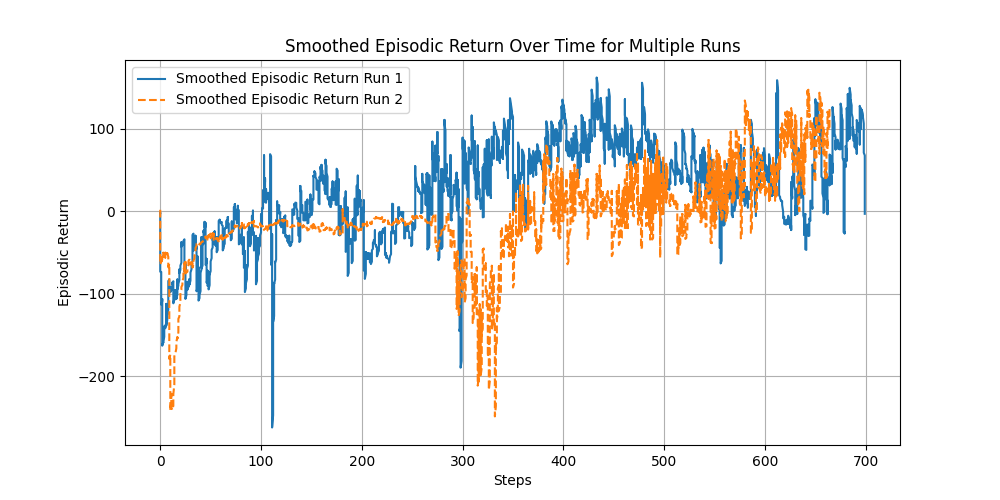

In [22]:
from IPython.display import Image, display

# Replace 'path_to_image.png' with the path to your actual image file
display(Image(filename='DDPG_smoothed_episodic_return_comparison.png'))

In [21]:
%tensorboard --logdir='tensorboard/ddpg'

Reusing TensorBoard on port 6006 (pid 26460), started 14:25:30 ago. (Use '!kill 26460' to kill it.)